# Set Up
Import your files, and set up your R environment.

In [ ]:
demo()
list.files(list.dirs())

Run the below `files.upload()`, selecting:
  'pathogen_results.csv',
 'amr_results.csv',
 'workshop_helper_scripts.R',
 'metadata.csv'

In [1]:
import os
from google.colab import files
uploaded = files.upload()

Saving amr_results.csv to amr_results (1).csv
Saving metadata.csv to metadata (1).csv
Saving pathogen_results.csv to pathogen_results (1).csv
Saving workshop_helper_scripts.R to workshop_helper_scripts (1).R


Check that your files are uploaded.

In [2]:
os.listdir()

['.config',
 'workshop_helper_scripts (1).R',
 'metadata (1).csv',
 'pathogen_results.csv',
 'amr_results.csv',
 'amr_results (1).csv',
 'workshop_helper_scripts.R',
 'pathogen_results (1).csv',
 'AMR_helper_files-20250304T014411Z-001.zip',
 'output',
 'metadata.csv',
 'sample_data']

Install R and switch the runtime environment.

In [3]:
!apt-get update -qq
!apt-get install -y r-base

# Install IRkernel and make it available in Jupyter
!R -e "install.packages('IRkernel')"
!R -e "IRkernel::installspec(user = FALSE)"

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.3-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.

R version 4.4.3 (2025-02-28) -- "Trophy Case"
Copyright (C) 2025 The R Foundation for Statistical Computing
Platform: x86_64-pc-linux-gnu

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

  Natural language support but running in an English locale

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line hel

# Run the R code
## Switch your Runtime environment to R
In the Google Colab dropdowns, go to `Runtime` > `Change runtime type`. Select `R` from the options. You should now be operating in R!

## Set up basics
Set up your basic params to source the files you uploaded. Also set up some basic parameters for plotting. You can change these to alter your plot format later.

In [1]:
#### BASIC SOURCE PARAMS ####
data_dirs <- "."
opt <- list()
opt[["logaction"]] <- c("print","save")

opt[['data-pattern']] <- 'amr_results.csv'
opt[["output-dir"]] <- "output"
opt[['metadata-path']] <- "metadata.csv"
opt[["source-scripts"]] <- 'workshop_helper_scripts.R'


In [2]:
#### PLOTTING PARAMS ####
opt[["plot-collection-date-by-day"]] <- T

opt[["plot-text-size-small"]] <- 8
opt[["plot-text-size-medium"]] <- 10
opt[["plot-text-size-large"]] <- 12
opt[["facet-nrow"]] <- 1
opt[["plot-width"]] <- 18
opt[["plot-height"]] <- 5

In [3]:
######## LIBRARIES ########
suppressPackageStartupMessages({
  if(!require("tidyverse")){install.packages("tidyverse") ; library(tidyverse)}
  if(!require("lubridate")){install.packages("lubridate") ; library(lubridate)}
  if(!require("cowplot")){install.packages("cowplot") ; library(cowplot)}
  if(!require("scales")){install.packages("scales") ; library(scales)}
  if(!require("ggplot2")){install.packages("ggplot2") ; library(ggplot2)}
  if(!require("plotly")){install.packages("plotly") ; library(plotly)}
})

######## ADD EXTRA VARIABLES ########
source(opt[["source-scripts"]])
# Outpath for all output
if(nchar(opt[["output-dir"]])==0){ opt[["output-dir"]] <- "output" }

plots_dir <- dir.check(file.path(opt[["output-dir"]], "plots"))
data_dir <- dir.check(file.path(opt[["output-dir"]], "data"))
log_dir <- dir.check(file.path(opt[["output-dir"]], "log"))

opt[["log-file"]] <- file.path(log_dir, "amr_heatmap_log.txt")

######## PRINT OPT ########
for(i in names(opt)){
  record_log(filepath=opt[["log-file"]],paste0("opt[['",i,"']] <- ",if(typeof(opt[[i]])=="character"){"'"},opt[[i]],if(typeof(opt[[i]])=="character"){"'"}),opt[["logaction"]])
}


[1] "opt[['logaction']] <- 'print'" "opt[['logaction']] <- 'save'" 
[1] "opt[['data-pattern']] <- 'amr_results.csv'"
[1] "opt[['output-dir']] <- 'output'"
[1] "opt[['metadata-path']] <- 'metadata.csv'"
[1] "opt[['source-scripts']] <- 'workshop_helper_scripts.R'"
[1] "opt[['plot-collection-date-by-day']] <- TRUE"
[1] "opt[['plot-text-size-small']] <- 8"
[1] "opt[['plot-text-size-medium']] <- 10"
[1] "opt[['plot-text-size-large']] <- 12"
[1] "opt[['facet-nrow']] <- 1"
[1] "opt[['plot-width']] <- 18"
[1] "opt[['plot-height']] <- 5"
[1] "opt[['log-file']] <- 'output/log/amr_heatmap_log.txt'"


# Ingest data
Ingest the data and link to metadata

In [4]:
filelist <- c()
for (dir in data_dirs) { filelist <- c(filelist, unique(list.files(dir, pattern = opt[["data-pattern"]], full.names = TRUE))) }

# Create a data frame combining all files
all_data0 <- do.call(rbind, lapply(filelist, function(file) {
  data <- read.csv(file)
  # Add a new column with the final directory name
  data$directory_folder <- basename(dirname(file))
  data$directory <- dirname(file)
  data$filename <- basename(file)
  return(data)
}))

# Bc we expect BARCODE to be present from Snowflake
if(!("Sample" %in% colnames(all_data0))){ all_data0$Sample <- all_data0$BARCODE }

record_log(filepath=opt[["log-file"]],paste0("FILES: ",data_dirs),opt[["logaction"]])
record_log(filepath=opt[["log-file"]],paste0("SAMPLE COUNT: ",length(unique(all_data0$Sample))),opt[["logaction"]])

all_data <- all_data0

###### CONNECT TO METDATA ######
md <- generate_md(opt[["metadata-path"]],
                  all_data,
                  opt[["log-file"]]
)

working_data <- add_md(all_data, md)

[1] "FILES: ."
[1] "SAMPLE COUNT: 35"
[1] "No column LabelName observed. Will use SampleName as labels instead."


View your AMR data combined with metadata.

In [ ]:
print(paste(colnames(working_data), collapse=", "))

[1] "Sample, ID, SEQUENCING_TUBE_ID, ORF_ID, UNIQUE_CONTIG_ORF, start, stop, ORIENTATION, CUTOFF, PASS_BITSCORE, BEST_HIT_BITSCORE, GENE_NAME, CONTIG_PERCENT_ID, ARO_ACCESSION, MODEL_TYPE, SNPS, OTHER_SNPS, DRUG_CLASS, RESISTANCE_MECHANISM, AMR_GENE_FAMILY, PREDICTED_DNA, PREDICTED_PROTEIN, CARD_PROTEIN_SEQUENCE, PERCENTAGE_LENGTH_OF_REFERENCE_SEQUENCE, CARD_ID, MODEL_ID, NUDGED, NOTE, HIT_START, HIT_END, ANTIBIOTIC, ASSOCIATED_SPECIES, TAXONOMIC_KMERS, GENOMIC_KMERS, CONTIG_LENGTH, NUMREADS, MEAN_CONTIG_COVERAGE_DEPTH, CONTIG_ORF_LENGTH, CONTIG, CONTIG_AS_PERC_REF, DB_GENE_LENGTH, GENE_COVERAGE_PERC, CLASSIFICATION_SOURCE, HIGH_LEVEL_DRUG_CLASS, NUM_CONTIGS, SAMPLE_MAPPED_READ_COUNT, TOTAL_SAMPLE_READ_COUNT, RPM, TOTAL_SAMPLE_BP_COUNT, DPM, RPK, RPK_COUNT, RPKM, TPM, BARCODE, directory_folder, directory, filename, COLLECTION_OPERATOR_INITIAL, COLLECTION_TOTAL_VOLUME, COLLECTION_DEVICE_NUMBER_NAME, COLLECTION_QUESTIONNAIRE_TIME, COLLECTION_SUCCESSFUL, COLLECTION_TEMPERATURE, RUN_NUMBER

In [ ]:
head(working_data)

,Sample,ID,SEQUENCING_TUBE_ID,ORF_ID,UNIQUE_CONTIG_ORF,start,stop,ORIENTATION,CUTOFF,PASS_BITSCORE,⋯,BFX_ANALYSIS_SUCCEEDED,BFX_RAW_READS,BFX_TRIMMED_READS,BFX_POSTHOST_READS,BFX_ANALYSIS_BY_TUBE_RN,BFX_ANALYSIS_BY_BARCODE_PANEL_RN,SS_RANK,LabelName,original_Sample,BothLabelName
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,⋯,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>
1,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_161846_1 # 3 # 365 # 1 # ID=74336_1;partial=10;start_type=Edge;rbs_motif=None;rbs_spacer=None;gc_cont=0.333,k99_161846_1,3,365,+,Strict,50,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790
2,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_124809_2 # 607 # 1311 # -1 # ID=139547_2;partial=01;start_type=Edge;rbs_motif=None;rbs_spacer=None;gc_cont=0.532,k99_124809_2,607,1311,-,Strict,450,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790
3,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_142920_33 # 29383 # 30546 # 1 # ID=13886_33;partial=00;start_type=ATG;rbs_motif=GGA/GAG/AGG;rbs_spacer=5-10bp;gc_cont=0.382,k99_142920_33,29383,30546,+,Strict,175,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790
4,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_31009_1 # 104 # 658 # 1 # ID=32699_1;partial=00;start_type=ATG;rbs_motif=GGA/GAG/AGG;rbs_spacer=5-10bp;gc_cont=0.578,k99_31009_1,104,658,+,Perfect,275,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790
5,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_40891_1 # 1 # 699 # -1 # ID=148466_1;partial=10;start_type=ATG;rbs_motif=GGA/GAG/AGG;rbs_spacer=5-10bp;gc_cont=0.602,k99_40891_1,1,699,-,Strict,175,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790
6,AVWWAAA26790,37b3b4c7-61a5-4ef9-8d53-d5a50f5ac1de,e169ca7e-32ed-47a3-9659-744a285b388d,k99_90178_1 # 105 # 602 # 1 # ID=65752_1;partial=00;start_type=ATG;rbs_motif=None;rbs_spacer=None;gc_cont=0.512,k99_90178_1,105,602,+,Perfect,300,⋯,True,18480314,17856737,17818493,1,1,1,AVWWAAA26790,AVWWAAA26790,AVWWAAA26790


In [ ]:
###### RESTRUCTURE THE DATA ######

#Collection date
working_data$COLLECTION_DATE <- convert_to_date(working_data$COLLECTION_DATE)
record_log(filepath=opt[["log-file"]], summary(working_data$COLLECTION_DATE), opt[["logaction"]])

#Collection week
working_data$COLLECTION_WEEK <- floor_date(working_data$COLLECTION_DATE, unit = "week", week_start = 7)
record_log(filepath=opt[["log-file"]], summary(working_data$COLLECTION_WEEK), opt[["logaction"]])

#site
working_data$TEST_LOCATION_NAME <- as.factor(working_data$TEST_LOCATION_NAME)
record_log(filepath=opt[["log-file"]], levels(working_data$TEST_LOCATION_NAME), opt[["logaction"]])

#RPKM: replace NA with 0 (these are the sequencing controls)
working_data$RPKM[which(is.na(working_data$RPKM)==TRUE)] <- 0
working_data$RPKM <- as.numeric(working_data$RPKM)
record_log(filepath=opt[["log-file"]], "#### RPKM INFO:", opt[["logaction"]])
record_log(filepath=opt[["log-file"]], summary(working_data$RPKM), opt[["logaction"]])

#ID
working_data$BARCODE <- as.factor(working_data$BARCODE)
record_log(filepath=opt[["log-file"]], "#### BARCODE INFO:", opt[["logaction"]])
record_log(filepath=opt[["log-file"]], summary(working_data$BARCODE), opt[["logaction"]])
record_log(filepath=opt[["log-file"]], length(levels(working_data$BARCODE)), opt[["logaction"]])

# LOCATION. just replace it, for ease
working_data$TEST_LOCATION_NAME_ORIGINAL <- working_data$TEST_LOCATION_NAME
working_data <- working_data %>%
  mutate(TEST_LOCATION_NAME = case_when(
    TEST_LOCATION_NAME == "Anakin" ~ "Building 9 Basement\nRoom 0220",
    TEST_LOCATION_NAME == "Dexter" ~ "10 Basement\nRoom 0200",
    TEST_LOCATION_NAME == "Jafar" ~ "Building 9\nExternal Manhole",
    TEST_LOCATION_NAME == "Bane" ~ "Building 9\nWest Basement 716",
    TEST_LOCATION_NAME == "Ursula" ~ "Building 9A\nSump Pump",
    TEST_LOCATION_NAME == "Thanos" ~ "Building 62\nExternal Manhole NE",
    TEST_LOCATION_NAME == "Draco" ~ "Building 19\nSump Room B034",
    TEST_LOCATION_NAME == "Loki" ~ "Building 19\nExternal Manhole",
    TRUE ~ TEST_LOCATION_NAME
  ))

# Set the summary date column based on the plot-collection-date-by-day option
summary_date_column <- if(opt[["plot-collection-date-by-day"]]){ "COLLECTION_DATE" } else { "COLLECTION_WEEK" }
working_data$DATE_PLOT_COLUMN <- working_data[[summary_date_column]]

#reduce columns for manageability
cols_keep <- c("BARCODE", "TEST_LOCATION_NAME", "DATE_PLOT_COLUMN", "COLLECTION_DATE", "COLLECTION_WEEK", "DRUG_CLASS", "HIGH_LEVEL_DRUG_CLASS", "RPKM")
working_data_reduced <-working_data[,which(colnames(working_data)%in%cols_keep)]
record_log(filepath=opt[["log-file"]], head(working_data_reduced), opt[["logaction"]])


In [ ]:
############ RENAME THE DRUG CLASSES ############
#bin drug classes

#remove any rows without drug class.
working_data_reduced <- working_data_reduced[working_data_reduced$HIGH_LEVEL_DRUG_CLASS!="",]

# Function to check if a given entry is a subset of MLS_classes
is_MLS_only <- function(entry) {
  components <- unlist(strsplit(entry, "; "))
  all(components %in% c("lincosamide", "macrolide", "streptogramin"))
}

# Standardize drug class names
working_data_reduced$HIGH_LEVEL_DRUG_CLASS <- gsub(" antibiotic", "", working_data_reduced$HIGH_LEVEL_DRUG_CLASS)
working_data_reduced$HIGH_LEVEL_DRUG_CLASS <- gsub("diaminopyrimidine", "trimethoprim", working_data_reduced$HIGH_LEVEL_DRUG_CLASS)
working_data_reduced$HIGH_LEVEL_DRUG_CLASS <- gsub("phosphonic acid", "fosfomycin", working_data_reduced$HIGH_LEVEL_DRUG_CLASS)

# Apply MLS filtering
working_data_reduced$HIGH_LEVEL_DRUG_CLASS[sapply(working_data_reduced$HIGH_LEVEL_DRUG_CLASS, is_MLS_only)] <- "MLS"

# Group multidrug classifications
working_data_reduced$HIGH_LEVEL_DRUG_CLASS[grep(";", working_data_reduced$HIGH_LEVEL_DRUG_CLASS)] <- "multidrug"

# Remove non-clinical drug classes
remove_classes <- c("aminocoumarin", "disinfecting agents and antiseptics", "elfamycin", "nucleoside")
working_data_reduced <- working_data_reduced[!working_data_reduced$HIGH_LEVEL_DRUG_CLASS %in% remove_classes, ]

# Remove specific drug classes from analysis
remove_drugs <- c("fosfomycin", "peptide", "nitroimidazole", "rifamycin")
working_data_reduced <- working_data_reduced[!working_data_reduced$HIGH_LEVEL_DRUG_CLASS %in% remove_drugs, ]
working_data_reduced <- droplevels(working_data_reduced)
working_data_reduced$HIGH_LEVEL_DRUG_CLASS <- as.factor(working_data_reduced$HIGH_LEVEL_DRUG_CLASS)
record_log(filepath=opt[["log-file"]], levels(working_data_reduced$HIGH_LEVEL_DRUG_CLASS), opt[["logaction"]])

###### SUMMARIZE DATA ######
#summarize data by week
summary_data <- working_data_reduced %>%
  group_by(DATE_PLOT_COLUMN, HIGH_LEVEL_DRUG_CLASS, TEST_LOCATION_NAME) %>%
  summarize(RPKM = sum(RPKM))

#add placeholder data for Loki
placeholder <- summary_data %>% filter(TEST_LOCATION_NAME == "Bane") %>% mutate(TEST_LOCATION_NAME = "Loki", RPKM = NA)
summary_data <- bind_rows(summary_data, placeholder)

## AMR Heatmap

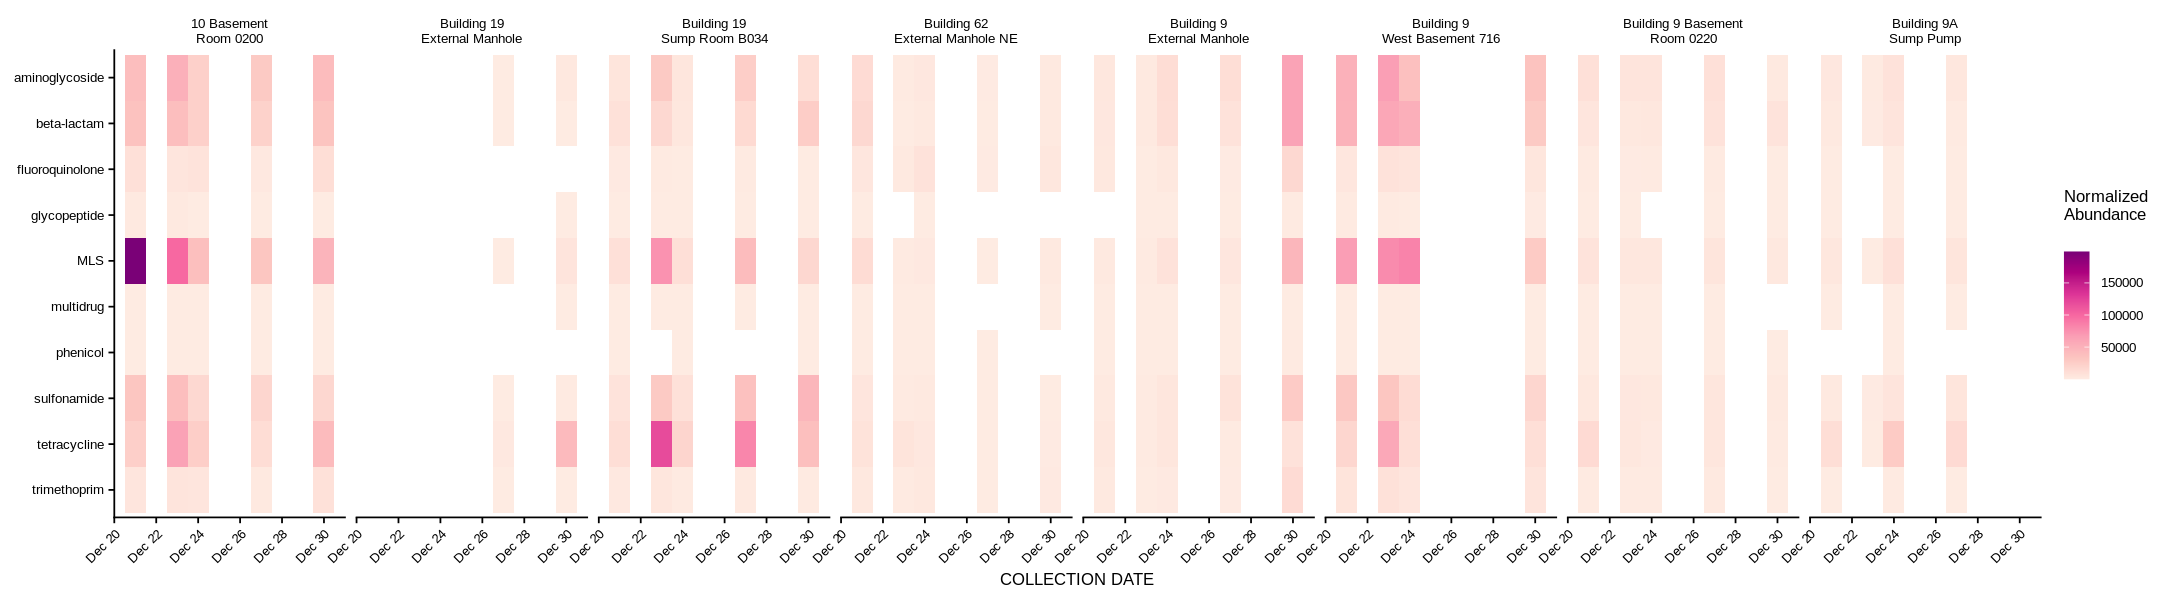

In [ ]:
###### PLOT DATA ######
#Plot heatmap using ggplot
options(repr.plot.width = opt[["plot-width"]], repr.plot.height = opt[["plot-height"]])
AMR_heat <- ggplot(summary_data, aes(DATE_PLOT_COLUMN, ordered(HIGH_LEVEL_DRUG_CLASS, levels=rev(levels(HIGH_LEVEL_DRUG_CLASS))), fill= RPKM)) +
  geom_tile()+
  scale_fill_distiller(palette = "RdPu", direction=1,
                       na.value="white",
                       name="Normalized\nAbundance\n") +
  scale_x_date(date_labels = "%b %d")+
  facet_wrap(~TEST_LOCATION_NAME, nrow=opt[["facet-nrow"]]) +
  theme_cowplot()+
  theme(axis.text.x = element_text(angle=45, hjust=1, size=opt[["plot-text-size-small"]]),
        axis.text.y = element_text(size=opt[["plot-text-size-small"]]),
        axis.title.y = element_blank(),
        axis.title.x = element_text(size=opt[["plot-text-size-medium"]]),
        strip.text = element_text(size=opt[["plot-text-size-small"]]),
        strip.background = element_blank(),
        legend.text = element_text(size=opt[["plot-text-size-small"]]),
        legend.title = element_text(size=opt[["plot-text-size-medium"]])) +
        xlab(sub("_", " ",summary_date_column))
  ggsave(file.path(plots_dir, "AMR_heatmap.png"), plot = AMR_heat, width = opt[["plot-width"]], height = opt[["plot-height"]], units = "in", dpi = 300)

  AMR_heat



In [ ]:
###### GET FAMILY TOTALS ######
#get summary data for key gene families

# Summarize AMR gene families
family_data <- working_data %>%
  group_by(AMR_GENE_FAMILY, BARCODE, DATE_PLOT_COLUMN, TEST_LOCATION_NAME) %>%
  summarize(RPKM = sum(RPKM), .groups = 'drop')

percent_pos <- family_data %>%
  group_by(AMR_GENE_FAMILY) %>%
  summarize(pos = sum(RPKM > 0), percent_pos = (pos / length(unique(family_data$BARCODE))) * 100, .groups = 'drop')

write.csv(percent_pos, file = file.path(data_dir, "percent_positive_AMR.csv"), row.names = FALSE)

#summarize by gene family
gene_data <- working_data %>%
  group_by(GENE_NAME, BARCODE, DATE_PLOT_COLUMN, TEST_LOCATION_NAME) %>%
  summarize(RPKM = sum(RPKM), .groups = 'drop')

percent_pos_gene <- gene_data %>%
  group_by(GENE_NAME) %>%
  summarize(pos = sum(RPKM > 0), percent_pos = (pos / length(unique(gene_data$BARCODE))) * 100, .groups = 'drop')

write.csv(percent_pos_gene, file = file.path(data_dir, "percent_positive_AMR_variants.csv"), row.names = FALSE)

In [ ]:
###### REVAMP DATA FOR SPECIFIC GENES (Copied from AMR_gene_detection) ######
AMR_data <- working_data
#For genes we want to plot, this replaces the AMR_GENE_FAMILY column entry with the
#name we want plotted.
#For select genes from GENE_NAME, replace entry in AMR_GENE_FAMILY for ease of plotting.
gene_replacements <- list(
  "vanA" = "vanA",
  "vanB" = "vanB",
  "OXA-48" = "OXA-48",
  "mecA" = "mecA"
)

family_replacements <- c("KPC", "NDM", "VIM", "IMP", "MCR")

for (gene in names(gene_replacements)) {
  AMR_data$AMR_GENE_FAMILY[AMR_data$GENE_NAME == gene] <- gene_replacements[[gene]]
}

for (family in family_replacements) {
  AMR_data$AMR_GENE_FAMILY[grep(family, AMR_data$AMR_GENE_FAMILY)] <- family
}

#make a new data set for select AMR genes. Subset this data, and add empty rows for undetected genes.

#summarize by AMR_GENE_FAMILY to remove duplicates of genes within samples.
sum_data <- AMR_data %>%
  group_by(BARCODE, TEST_LOCATION_NAME, DATE_PLOT_COLUMN, AMR_GENE_FAMILY)%>%
  summarize(RPKM = sum(RPKM))

#pivot data frame wide
wide_data <- pivot_wider(sum_data, id_cols=c(BARCODE, TEST_LOCATION_NAME, DATE_PLOT_COLUMN), names_from = AMR_GENE_FAMILY, values_from = RPKM, values_fill = 0)

#list target genes
key_genes <- c("KPC", "VIM", "IMP", "NDM", "OXA-48", "vanA", "vanB", "MCR", "mecA")

#reduce data frame to target genes
ARG_cols <- c("BARCODE", "TEST_LOCATION_NAME", "DATE_PLOT_COLUMN", key_genes)
ARG_data <- wide_data[,which(colnames(wide_data)%in%ARG_cols)]

#add column for any missing key genes in data set
for (gene in key_genes) {
  if (!gene %in% colnames(ARG_data)) {
    ARG_data[[gene]] <- 0
  }
}

#format date and site
ARG_data$DATE_PLOT_COLUMN <- as.Date(ARG_data$DATE_PLOT_COLUMN, format="%m/%d/%y")
ARG_data$TEST_LOCATION_NAME <- as.factor(ARG_data$TEST_LOCATION_NAME)

#pivot long
ARG_long <- pivot_longer(ARG_data, cols = key_genes, names_to = "Gene", values_to = "RPKM")
ARG_long$Gene <- as.factor(ARG_long$Gene)

#reorder factor levels for ARG pathogens
ARG_long$Gene <- factor(ARG_long$Gene,
                        levels = rev(key_genes))

# Summarize by week and location
summary_data <- ARG_long %>%
  group_by(DATE_PLOT_COLUMN, TEST_LOCATION_NAME, Gene) %>%
  summarize(RPKM = sum(RPKM), .groups = "drop")

# Add detected/not detected column
summary_data <- summary_data %>%
  mutate(
    detected = factor(RPKM > 0, levels = c(FALSE, TRUE), labels = c("FALSE", "TRUE"))
  )

#add column for gene type
summary_data$type <- case_when(
  grepl("van", summary_data$Gene) ~ "VRE",
  grepl("mecA", summary_data$Gene) ~ "MRSA",
  grepl("MCR", summary_data$Gene) ~ "colistin",
  TRUE ~ "CRE"
)

#add column for color
summary_data$color <- as.factor(ifelse(summary_data$detected == "TRUE", summary_data$type, "notdetected"))

`summarise()` has grouped output by 'BARCODE', 'TEST_LOCATION_NAME',
'DATE_PLOT_COLUMN'. You can override using the `.groups` argument.
Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(key_genes)

  # Now:
  data %>% select(all_of(key_genes))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


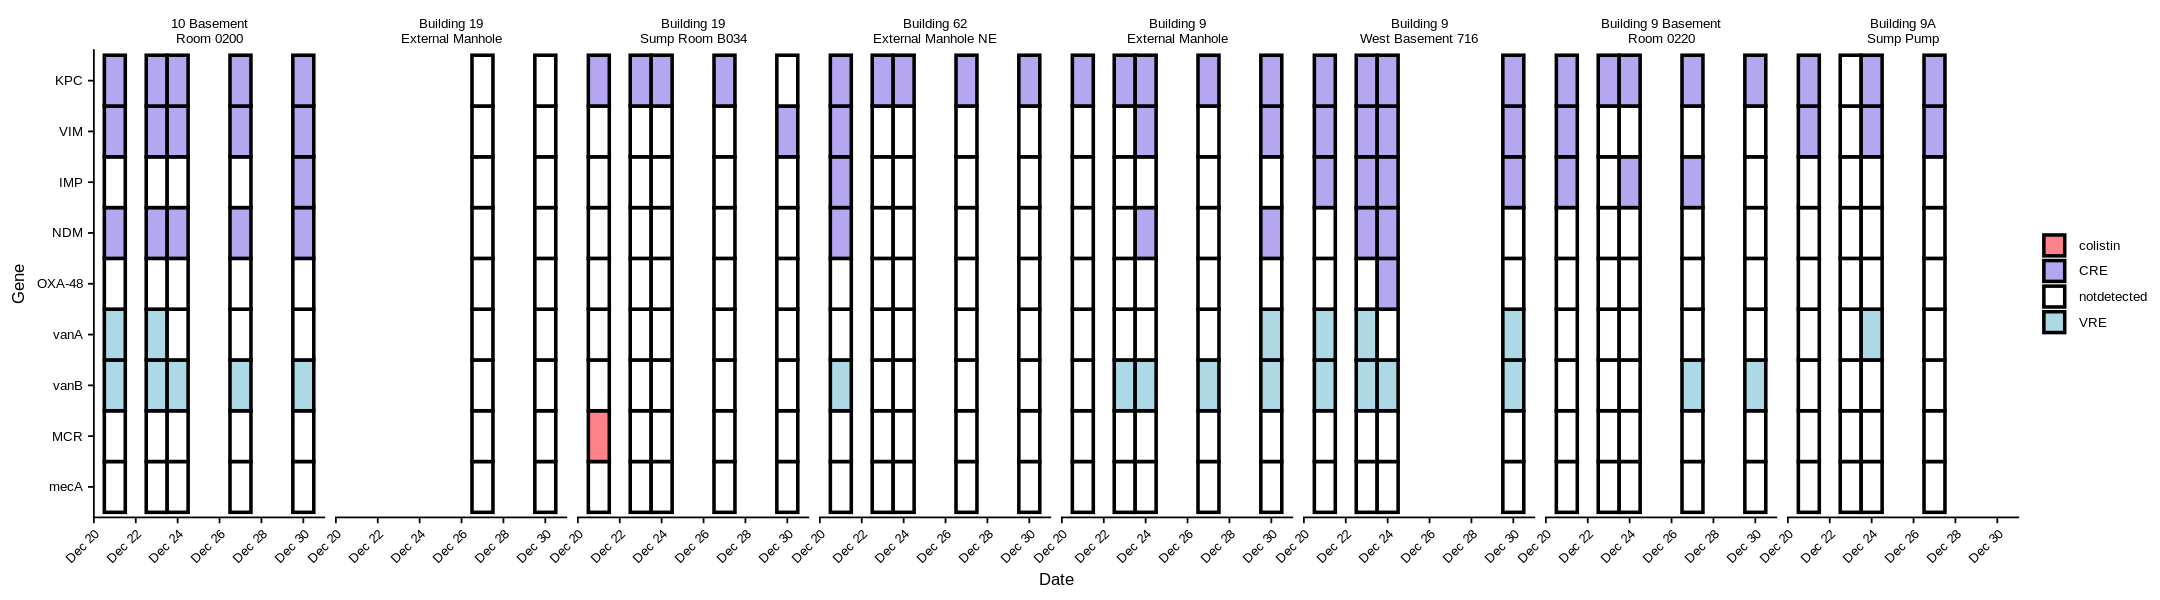

In [ ]:
###### PLOT SPECIFIC GENES ######

options(repr.plot.width = opt[["plot-width"]], repr.plot.height = opt[["plot-height"]])
gene_plot <- ggplot(data=summary_data, aes(x=DATE_PLOT_COLUMN, y=Gene, fill=color))+
  geom_tile(color="black", linewidth=1) +
  facet_wrap(~TEST_LOCATION_NAME, nrow=opt[["facet-nrow"]]) +
  scale_fill_manual(values=c("#FF828B", "#B5A6F0",  "white", "lightblue"))+
  scale_x_date(name="Date")+
  theme_cowplot()+
  theme(axis.title = element_text(size=opt[["plot-text-size-medium"]]),
        axis.text.y = element_text(size=opt[["plot-text-size-small"]]),
        axis.text.x = element_text(size=opt[["plot-text-size-small"]], angle=45, hjust=1),
        strip.text = element_text(size=opt[["plot-text-size-small"]]),
        plot.title = element_text(size=opt[["plot-text-size-medium"]], hjust=0.5),
        legend.text = element_text(size=opt[["plot-text-size-small"]]),
        legend.title = element_blank(),
        strip.background = element_blank())

gene_plot
ggsave(file.path(plots_dir, "AMR_genes.png"), plot = gene_plot, width = opt[["plot-width"]], height = opt[["plot-height"]], units = "in", dpi = 300)


In [ ]:
#can you say anything about key genes by site?
record_log(filepath=opt[["log-file"]], summary(working_data$TEST_LOCATION_NAME[which(working_data$GENE_NAME=="vanA")]), opt[["logaction"]])
record_log(filepath=opt[["log-file"]], length(working_data$TEST_LOCATION_NAME[which(working_data$GENE_NAME=="vanA")]), opt[["logaction"]])

record_log(filepath=opt[["log-file"]], summary(working_data$TEST_LOCATION_NAME[grep("msr", working_data$GENE_NAME)]), opt[["logaction"]])
record_log(filepath=opt[["log-file"]], length(working_data$TEST_LOCATION_NAME[grep("msr", working_data$GENE_NAME)]), opt[["logaction"]])

record_log(filepath=opt[["log-file"]], summary(working_data$TEST_LOCATION_NAME[grep("NDM", working_data$GENE_NAME)]), opt[["logaction"]])
record_log(filepath=opt[["log-file"]], length(working_data$TEST_LOCATION_NAME[grep("msr", working_data$GENE_NAME)]), opt[["logaction"]])

record_log(filepath=opt[["log-file"]], paste0("writing to ",file.path(opt[["output-dir"]],"amr_heatmap.Rdata")), opt[["logaction"]])


   Length     Class      Mode 
        7 character character 
[1] 7
   Length     Class      Mode 
       33 character character 
[1] 33
   Length     Class      Mode 
       10 character character 
[1] 33
[1] "writing to output/amr_heatmap.Rdata"
